In [1]:
from __future__ import division

from pylab import *
import scipy
import time
import utils
import hrr_utils

#import imnet_utils as imut
import sklearn
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF
from scipy import stats

%matplotlib inline

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [22]:
def ngram_encode(ngram_str, letter_vecs, alph):
    vec = np.zeros(letter_vecs.shape[1])
    
    full_str = '#' + ngram_str + '.'
    
    
    for il, l in enumerate(full_str[:-2]):
        trivec = letter_vecs[alph.find(full_str[il]), :]
        for c3 in range(1, 3):
            trivec = trivec * np.roll(letter_vecs[alph.find(full_str[il+c3]), :], c3)
            
        vec += trivec
    return vec

def ngram_encode_cl(ngram_str, letter_vecs, alph):
    vec = ngram_encode(ngram_str, letter_vecs, alph)
    
    return 2* (vec + 0.1*(np.random.rand(letter_vecs.shape[1])-0.5) > 0) - 1

def bind(past, present):
    return np.multiply(past, present)

def reg_bind(past, present):
    pred = np.multiply(tv, present)
    return ((N-sim(pred, past))/float(N)) * np.multiply(past, present)

def bind_diff(past2, present1, present2):
    return np.multiply(present1, past2-present2)

def reg_bind_diff(past2, present1, present2):
    pred = np.multiply(tv, present1) + present2
    return ((N-sim(pred, past2))/float(N)) * np.multiply(past2-present2, present1)

def closed_bind(past, present):
    return np.dot(np.linalg.pinv(present), past)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def state_setup(state_length, letter_vecs, N, D, n_steps=500):
    states = []
    coef_hists = []
    
    for i in range(state_length):
        states.append(np.random.randn(N))
    
    for i in range(1, state_length-1):
        states[i] = np.dot(letter_vecs.T, np.dot(states[i], letter_vecs.T))

    for i in range(1, state_length-1):
        states[i] = states[i]/norm(states[i])

    states[0] = letter_vecs[alph.find('#'), :]
    states[state_length-1] = letter_vecs[alph.find('.'), :]
    
    for i in range(1, state_length-1):
        coef_hists.append(np.zeros((n_steps, D)))
    
    return states, coef_hists

# EXPLAIN AWAY, PAST PRESENT TENSE DIFFERENCE
def explain_away_iterate(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, n_steps):
    th_vec = bound_vec.copy()
    
    for i in range(n_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            ## Need to make sure that the largest absolute value is always positive,
            ## because the unbinding inference can flip 2 and be the same

            #mxidx = np.argmax(np.abs(coef_hists[j-1][i,:]))
            #states[j] *= np.sign(coef_hists[j-1][i, mxidx])
            
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv

    return states, coef_hists

def spell(coef_hists):
    pred = ''
    alphis = []
    for i in range(len(coef_hists)):
        alphis.append(np.argmax(np.abs(coef_hists[i][-1,:])))
        pred += alph[alphis[i]]
    return pred
    
def resplot(word_length, states, coef_hists, N, nsteps):
    
    pred = spell(coef_hists)
    
    rows = 1
    columns = word_length

    fig, axes = plt.subplots(rows, columns, sharex='all', squeeze=True, figsize=(25,5))
    cols = get_cmap('copper', min(500,n_steps))
    x = np.linspace(0,len(alph)-2,len(alph)-2)
    labels = list(alph)
    plt.xticks(x, labels)
    
    for j in range(word_length):
        for i in range(min(500,n_steps)):
            # graphing the max positive at every iteration is not intuitive, since we should
            # be focusing on how our predicted letter's probability increases over time
            coef_hists[j][i,alphis[j]] = np.abs(coef_hists[j][i,alphis[j]])
            axes[j].plot(coef_hists[j][i,:], lw=1.7, c=cols(i))
            
        step, alphi = np.unravel_index(coef_hists[j].argmax(), coef_hists[j].shape)
        axes[j].plot(alphi, coef_hists[j][step, alphi], '+')
    
    #plt.savefig('figures/'+title+pred+'-N='+str(N)+'-steps='+str(nsteps)+'-reg='+reg+'.svg')
    
def accuracy(pred, actual):
    acc = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            acc += 1
    return acc / float(len(pred))


In [23]:
alph = 'abcdefghijklmnopqrstuvwxyz#.'

N = 1000
D = len(alph)

word = 'pneumonoultramicroscopicsilicovolcanoconiosis'
n_steps = 70

In [41]:
def explain_away(bound_vec, states, coef_hists, state_length, letter_vecs, N, D, max_steps=500):
    th_vec = bound_vec.copy()
    all_converged = np.zeros(state_length-2)
    all_diffs = np.zeros((state_length-2, D))
    for i in range(max_steps):
        for j in range(1, state_length-1):
            coef_hists[j-1][i, :] = np.dot(letter_vecs, states[j])
            
            if i > 1:
                all_converged[j-1] = np.allclose(coef_hists[j-1][i,:], coef_hists[j-1][i-1, :],
                                                atol=2e-2, rtol=2e-2)
                all_diffs[j-1] = coef_hists[j-1][i,:] - coef_hists[j-1][i-1, :]
                
            if j == 1:
                ljd = (np.roll(th_vec * states[0] * np.roll(states[j+1], 2), -1) +
                  th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 2
            elif 1 < j < state_length-2:
                ljd = (np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2) +
                    np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                      th_vec * np.roll(states[j+1], 1) * np.roll(states[j+2], 2)) / 3
            else:
                ljd = (np.roll(th_vec * states[j-1] * np.roll(states[j+1], 2), -1) +
                   np.roll(th_vec * states[j-2] * np.roll(states[j-1], 1), -2)) / 2

            states[j] = np.dot(letter_vecs.T, np.dot(ljd, letter_vecs.T)/N) + 1.0*states[j]
            #states[j] = states[j]/norm(states[j])
        if i > 1:
            print ('all_converged', all_converged)
            #print ('diffs', all_diffs)

            
        if np.all(all_converged):
            print 'converged:', i,
            break
            
        bv = states[0] * np.roll(states[1],1) * np.roll(states[2],2) 
              
        for j in range(1, state_length-2):
            bv += states[j] * np.roll(states[j+1],1) * np.roll(states[j+2],2) 
         
        #bv = 2*(bv > 0) - 1

        th_vec = bound_vec - bv
    print ('diffs', all_diffs)
    return states, coef_hists

N = 5000
word_length = 5
dic1 = 2 * (np.random.randn(D, N) < 0) - 1
nsteps = 100

word_vec = ngram_encode_cl(word[:word_length], dic1, alph)
states, coef_hists = state_setup(word_length+2, dic1, N, D, nsteps)
states, coef_hists = explain_away(word_vec, states, coef_hists, word_length+2, dic1, N, D, nsteps)
pred = spell(coef_hists)
actual = word[:word_length]
print (pred, actual)

('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  1.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_converged', array([ 0.,  0.,  0.,  0.,  0.]))
('all_conver

In [25]:
accs = []
acci = 0

# N-neurons
for i in range(1,11):
    N = i*1000
    dic1 = 2 * (np.random.randn(D, N) < 0) - 1
    accs.append([])
    print ('N', N)
    
    # noise 
    for sigma in range(5):
        noise = np.random.normal(0, sigma*.01, N)
        accs[acci].append([])
        print ('sigma', sigma*.01)
        
        # M-letter word
        for word_length in range(2,len(word),5):
            word_vec = ngram_encode_cl(word[:word_length], dic1, alph) + noise
            states, coef_hists = state_setup(word_length+2, dic1, N, D, n_steps)
            states, coef_hists = explain_away_iterate(word_vec, states, coef_hists, word_length+2, dic1, N, D, n_steps)
            pred = spell(coef_hists)
            actual = word[:word_length]
            print (pred, actual)
            accs[acci][sigma].append(accuracy(pred, actual))
        
    acci += 1


('N', 1000)
('sigma', 0.0)
('pn', 'pn')
('pnejxet', 'pneumon')
('pneuwroqultr', 'pneumonoultr')
('ijwamoqhfy.zyoicr', 'pneumonoultramicr')
('ggcilgwlwqxslnbpzsdiop', 'pneumonoultramicroscop')
('ya#d#qvakjkicltlc#isjzoauil', 'pneumonoultramicroscopicsil')


KeyboardInterrupt: 

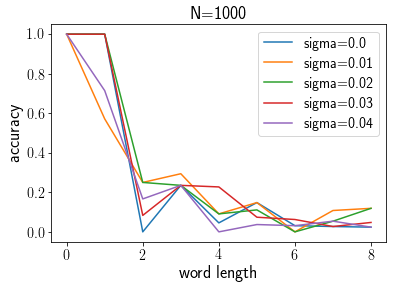

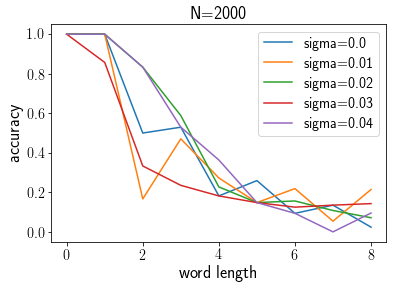

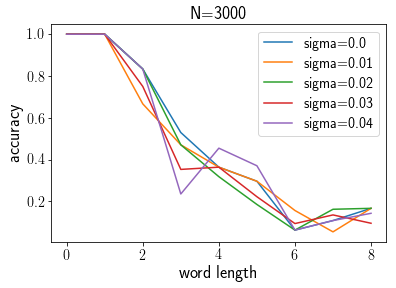

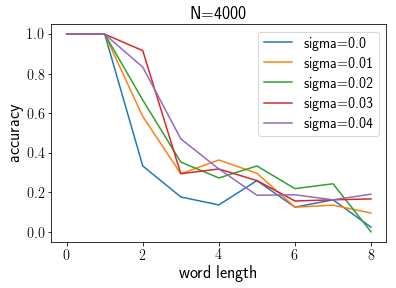

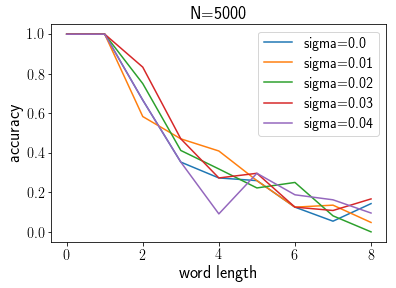

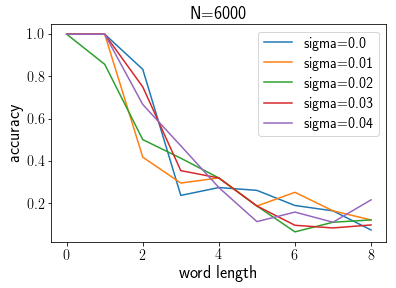

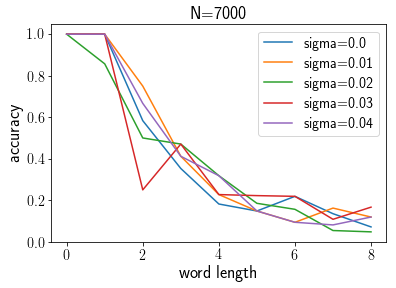

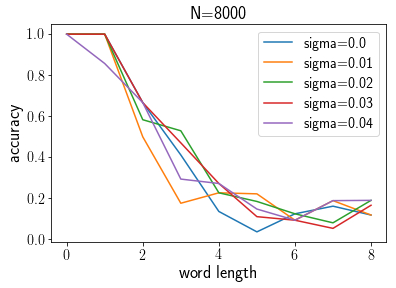

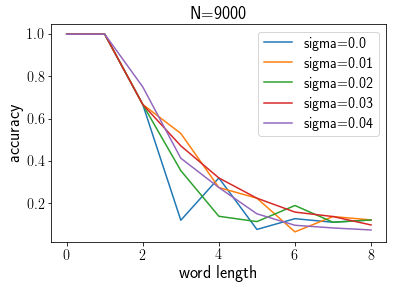

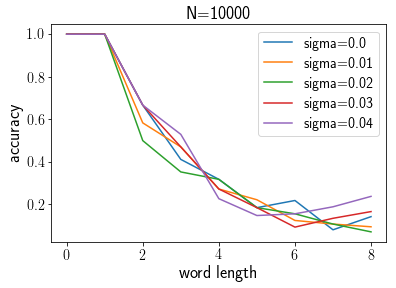

In [19]:


for i in range(len(accs)):
    plt.figure()
    for j in range(len(accs[i])):
        plt.plot(accs[i][j], label='sigma='+str(j*.01))
    plt.legend()
    plt.title('N='+str((i+1)*1000))    
    plt.ylabel('accuracy')
    plt.xlabel('word length')
    plt.show()

In [10]:
for i in range(len(accs)):
    print accs[i]

[[1.0, 1.0, 0.0, 0.23529411764705882, 0.045454545454545456, 0.14814814814814814, 0.03125, 0.02702702702702703, 0.023809523809523808], [1.0, 0.5714285714285714, 0.25, 0.29411764705882354, 0.09090909090909091, 0.14814814814814814, 0.0, 0.10810810810810811, 0.11904761904761904], [1.0, 1.0, 0.25, 0.23529411764705882, 0.09090909090909091, 0.1111111111111111, 0.0, 0.05405405405405406, 0.11904761904761904], [1.0, 1.0, 0.08333333333333333, 0.23529411764705882, 0.22727272727272727, 0.07407407407407407, 0.0625, 0.02702702702702703, 0.047619047619047616], [1.0, 0.7142857142857143, 0.16666666666666666, 0.23529411764705882, 0.0, 0.037037037037037035, 0.03125, 0.05405405405405406, 0.023809523809523808]]
[[1.0, 1.0, 0.5, 0.5294117647058824, 0.18181818181818182, 0.25925925925925924, 0.09375, 0.13513513513513514, 0.023809523809523808], [1.0, 1.0, 0.16666666666666666, 0.47058823529411764, 0.2727272727272727, 0.14814814814814814, 0.21875, 0.05405405405405406, 0.21428571428571427], [1.0, 1.0, 0.8333333333